# Notebook for the paper "Lip Abnormality Detection for Patients with Repaired Cleft Lip and Palate: A Lip Normalization Approach" 

## Authors: Karen Rosero, Ali Salman, Rami Hallac, and Carlos Busso

### Import libraries

In [1]:
import utility_functions.utils as uf
import numpy as np
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from third_party.pyto_tool import EarlyStopping
import random
import os
import torchvision
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Model hyperparameters

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)
batch_size = 16
threshold = 57
learning_rate = 0.00001
patience = 3
n_epochs = 50
dir_path = './results/siamesecnn_checkpoint.pt'

### Import data

In [3]:
# Control adult image subsets
train_cr = pd.read_csv('./data/split_data/train_cr.csv')
val_cr   = pd.read_csv('./data/split_data/val_cr.csv')
test_cr  = pd.read_csv('./data/split_data/test_cr.csv')

# Augmented adult image subsets
train_au = pd.read_csv('./data/split_data/train_au.csv')
val_au   = pd.read_csv('./data/split_data/val_au.csv')
test_au  = pd.read_csv('./data/split_data/test_au.csv')

# Control children image subsets
train_Ccr = pd.read_csv('./data/split_data/train_Ccr.csv')
val_Ccr   = pd.read_csv('./data/split_data/val_Ccr.csv')
test_Ccr  = pd.read_csv('./data/split_data/test_Ccr.csv')

# Augmented children image subsets
train_Cau = pd.read_csv('./data/split_data/train_Cau.csv')
val_Cau   = pd.read_csv('./data/split_data/val_Cau.csv')
test_Cau  = pd.read_csv('./data/split_data/test_Cau.csv')

# CLP images 
clp = './data/CLP/'
clp_m = './data/CLP_norm/'
common_files_clp = uf.common_files(clp, clp_m, '.npy')
clp_m_path = [clp_m+path.split('.')[-2]+'.png' for path in common_files_clp]
clp_path = [clp+path.split('.')[-2]+'.png' for path in common_files_clp]

In [4]:
# Concat subsets of adults, children for train, val, test
train_df = pd.concat([train_cr, train_au, train_Ccr, train_Cau], ignore_index=True)
val_df = pd.concat([val_cr, val_au, val_Ccr, val_Cau], ignore_index=True)
test_df = pd.concat([test_cr, test_au, test_Ccr, test_Cau], ignore_index=True)

test_cr = test_cr.reset_index(drop=True)
test_Ccr = test_Ccr.reset_index(drop=True)

test_clp = pd.DataFrame(data={'img': clp_path, 'img_n': clp_m_path, 'label':[0] * len(clp_m_path)})

print('Train samples:', len(train_df), '\nVal samples:',len(val_df), 
      '\nTest samples:',len(test_df),  '\nTest adult samples:',len(test_cr), 
      '\nTest children samples:',len(test_Ccr), '\nTest CLP samples:',len(test_clp))

Train samples: 2299 
Val samples: 577 
Test samples: 511 
Test adult samples: 186 
Test children samples: 69 
Test CLP samples: 395


In [5]:
class LipsDataset(Dataset):
    
    def __init__(self, data_dir, transform=None, dataset_name=None):
        self.transform = transform
        self.data = data_dir
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
            
        # Get images before and after normalization   
        path = self.data.loc[idx, 'img']
        path_m = self.data.loc[idx, 'img_n']
        img = cv2.imread(path)
        img_m = cv2.imread(path_m)
        
        # Get label
        label = self.data.loc[idx, 'label']
        
        # Get landmarks        
        if (self.dataset_name is 'CLP2'):
            lks = np.load(path_m[:-3]+'npy')
        else:
            lks = np.load(path[:-3]+'npy')
            

        # Crop images based on the lip landmarks    
        img, _ = uf.crop_img_lks_lips(img, lks, 0.2)      
        img_m, _ = uf.crop_img_lks_lips(img_m, lks, 0.2)
        
        if self.transform:
            img = self.transform(img)
            img_m = self.transform(img_m)
            
        return img, img_m, label

In [6]:
preprocess = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))   , 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#### Dataloaders definition

In [7]:
train_dataset = LipsDataset(train_df, transform = preprocess, dataset_name=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = LipsDataset(val_df, transform = preprocess, dataset_name=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LipsDataset(test_df, transform = preprocess, dataset_name=None)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_clp_dataset = LipsDataset(test_clp, transform = preprocess, dataset_name='CLP2')
test_clp_dataloader = DataLoader(test_clp_dataset, batch_size=batch_size, shuffle=False)

test_child_dataset = LipsDataset(test_Ccr, transform = preprocess, dataset_name=None)
test_child_dataloader = DataLoader(test_child_dataset, batch_size=batch_size, shuffle=False)

test_adult_dataset = LipsDataset(test_cr, transform = preprocess,  dataset_name=None)
test_adult_dataloader = DataLoader(test_adult_dataset, batch_size=batch_size, shuffle=False)

tensor(0)


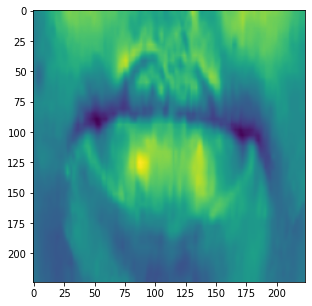

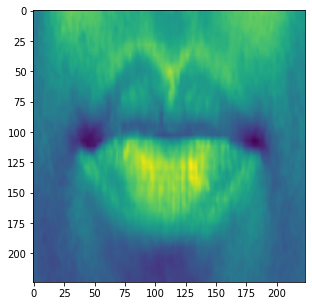

tensor(0)


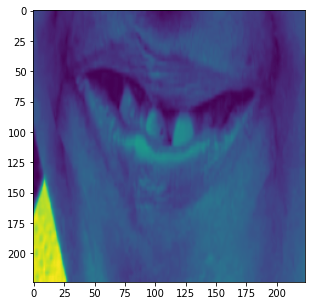

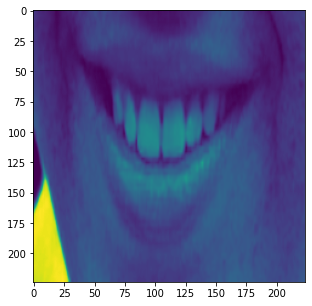

tensor(0)


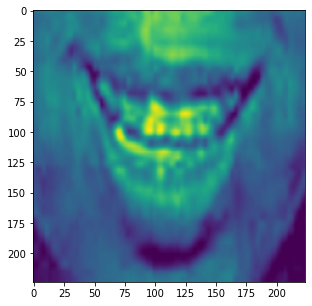

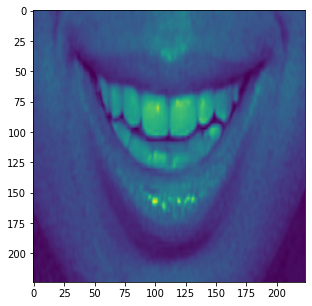

tensor(0)


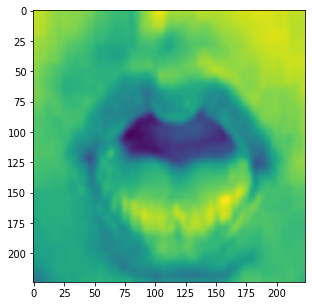

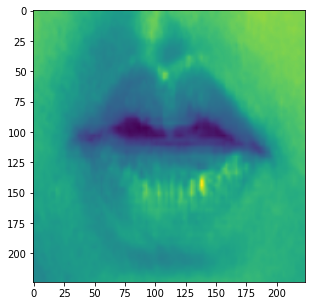

tensor(0)


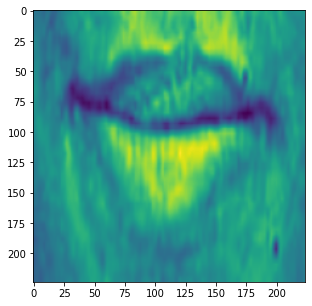

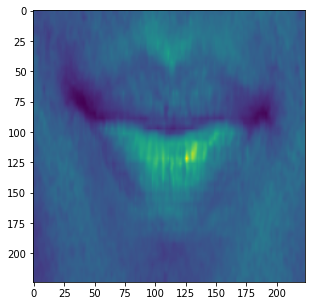

tensor(0)


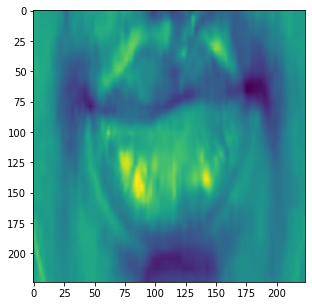

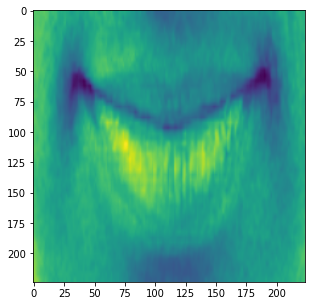

tensor(0)


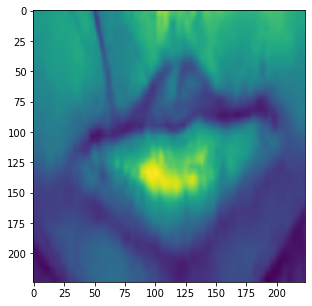

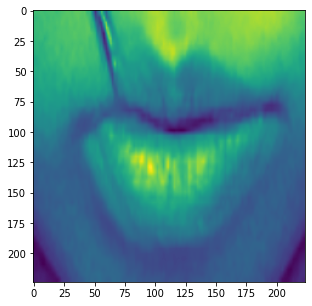

tensor(0)


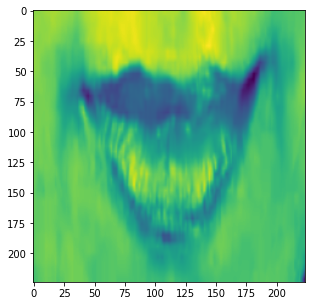

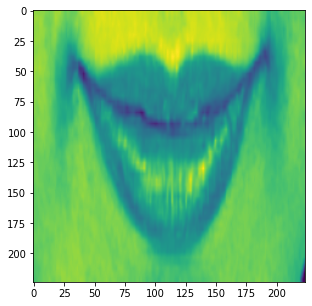

tensor(0)


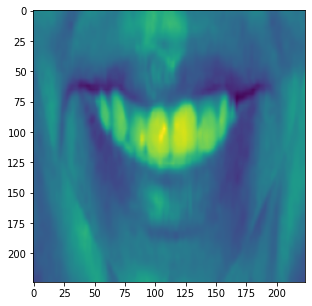

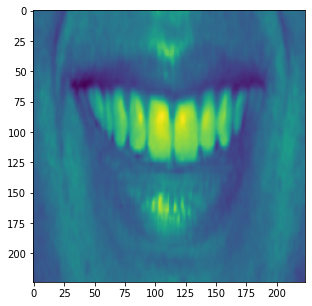

tensor(0)


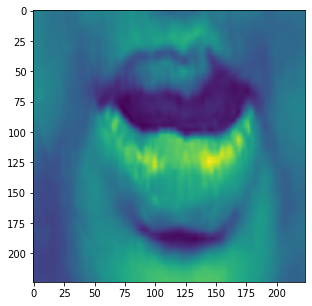

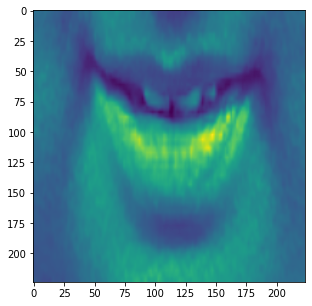

tensor(0)


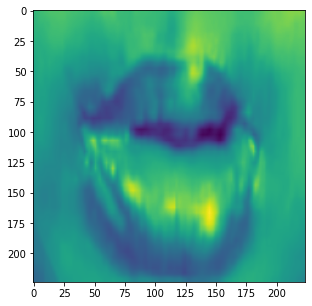

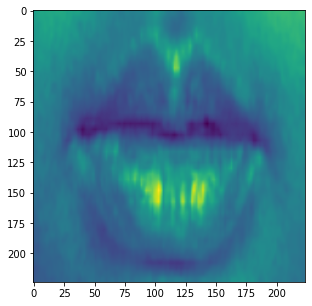

tensor(0)


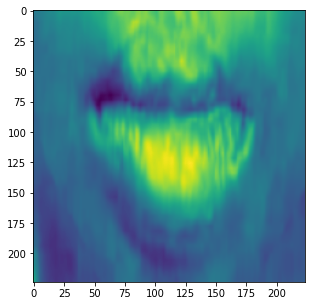

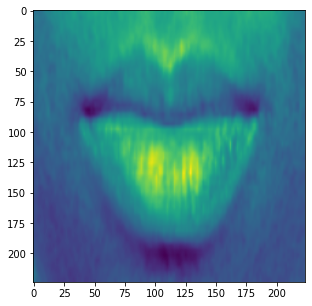

tensor(0)


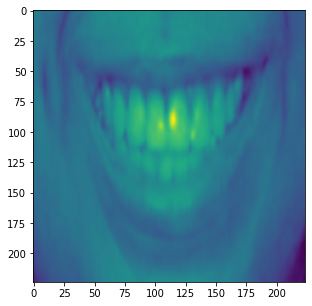

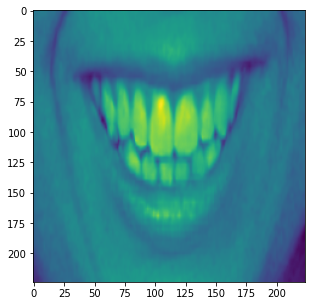

tensor(0)


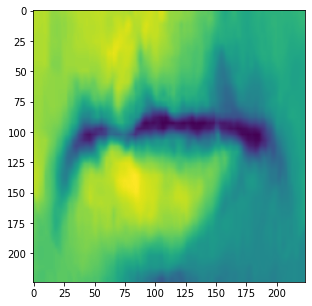

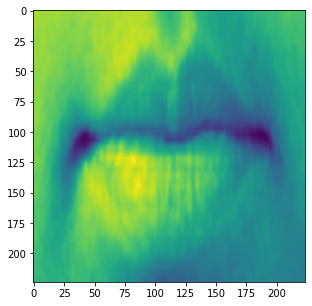

tensor(0)


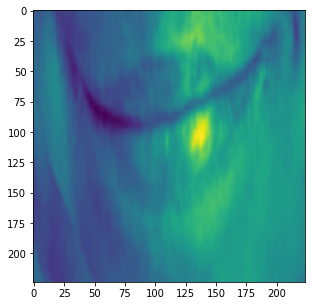

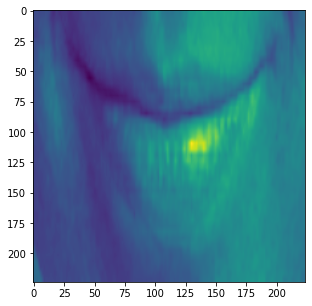

tensor(0)


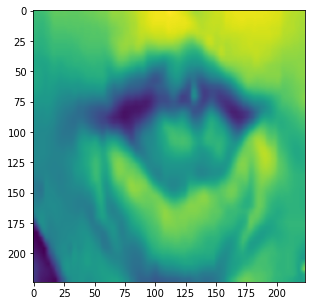

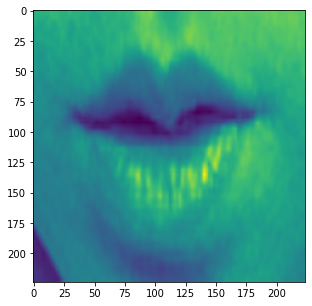

In [8]:
for lips, lips_m, label in test_clp_dataloader:
    lips = torch.permute(lips, (0,2,3,1))
    lips_m = torch.permute(lips_m, (0,2,3,1))
    for i in range(len(lips)):
        print(label[i])
        plt.figure(figsize=(5,5))
        plt.imshow(lips[i][:,:,0])
        plt.show()
        plt.figure(figsize=(5,5))
        plt.imshow(lips_m[i][:,:,0])
        plt.show()        
    break

### Siamese CNN

In [9]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)#weights='IMAGENET1K_V1') 
        self.model.classifier[-1] = torch.nn.Identity()
        self.clp1 = torch.nn.Linear(1280*2, 128)
        self.drop = torch.nn.Dropout(p = 0.2) 
        self.clp2 = torch.nn.Linear(128, 2)
        
    def _sample_forward_lip(self, x):
        out = self.model(x)
        return out
     
    def forward(self, lip, lip_m):
        
        out_emb = self._sample_forward_lip(lip)
        out_emb_m = self._sample_forward_lip(lip_m)

        out_concat = torch.cat((out_emb, out_emb_m), 1)
        
        out_concat = F.relu(self.clp1(out_concat))
        out_concat = self.drop(out_concat)
        out_concat = self.clp2(out_concat)

        return out_concat

#### Model instance

In [10]:
device = 'cuda'
model = SiameseCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
early_stopping = EarlyStopping(patience=patience, verbose=True)
criterion_class = torch.nn.CrossEntropyLoss()

# Number of layers to be finetuned, defined by threshold
for i, param in enumerate(model.model.features.parameters()):
    if i < threshold:
        param.requires_grad = False
    elif i >= threshold:
        param.requires_grad = True

Using cache found in /home/kgrosero/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kgrosero/miniconda3/envs/syncnet/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kgrosero/miniconda3/envs/syncnet/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Training loop

In [11]:
for epoch in range(1, n_epochs + 1):
    ###################   
    # train the model #
    ###################
    
    print("Training epoch:", epoch, end='')
    train_loss = []
    train_acc = []
    model.train()
    
    for img_lip, img_lip_m, label in tqdm(train_dataloader):
        img_lip = img_lip.to(device)
        img_lip_m = img_lip_m.to(device)
        label = label.to(device) 

        optimizer.zero_grad()
        
        clp_class = model(img_lip, img_lip_m)
        loss = criterion_class(clp_class, label) 
        value, pred = torch.max(clp_class, 1)    
        correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())
        loss.backward()
        optimizer.step()
        
        # save training losses 
        train_loss.append(loss.detach().to('cpu'))
        train_acc.append(correct_tensor)
    
    train_acc = np.sum(np.array(train_acc))
    print('Train accuracy: ', train_acc/len(train_df))    
    train_loss = np.average(np.array(train_loss))
    print('Train loss: ', train_loss) 

    ######################    
    # validate the model #
    ######################
 
    valid_loss = []
    valid_acc = []
    
    model.eval() 
    for img_lip, img_lip_m, label in tqdm(val_dataloader):
        
        img_lip = img_lip.to(device)
        img_lip_m = img_lip_m.to(device)
        label = label.to(device) 
        
        clp_class = model(img_lip, img_lip_m)
        loss = criterion_class(clp_class, label) 
        value, pred = torch.max(clp_class, 1)    
        correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())
        
        valid_loss.append(loss.detach().to('cpu'))
        valid_acc.append(correct_tensor)
    
    valid_acc = np.sum(np.array(valid_acc))/len(val_df)
    print('Valid accuracy: ', valid_acc)    
    valid_loss = np.average(np.array(valid_loss))
    print('Valid loss: ', valid_loss) 

    # Early_stopping checks if the validation loss has decresed
    early_stopping(valid_loss, model)
    # Save the best model
    torch.save(model.state_dict(), dir_path)

    if early_stopping.early_stop:
        print("Model early stopped")
        break 

Training epoch: 1

100%|██████████| 144/144 [00:26<00:00,  5.34it/s]


Train accuracy:  0.5706829056111353
Train loss:  0.6774761


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Valid accuracy:  0.729636048526863
Valid loss:  0.6478124
Validation loss decreased (inf --> 0.647812).  Saving model ...
Training epoch: 2

100%|██████████| 144/144 [00:24<00:00,  6.00it/s]


Train accuracy:  0.729447585906916
Train loss:  0.6104839


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Valid accuracy:  0.8336221837088388
Valid loss:  0.5278925
Validation loss decreased (0.647812 --> 0.527892).  Saving model ...
Training epoch: 3

100%|██████████| 144/144 [00:28<00:00,  5.07it/s]


Train accuracy:  0.8534145280556764
Train loss:  0.44189015


100%|██████████| 37/37 [00:05<00:00,  6.24it/s]


Valid accuracy:  0.9150779896013865
Valid loss:  0.30387676
Validation loss decreased (0.527892 --> 0.303877).  Saving model ...
Training epoch: 4

100%|██████████| 144/144 [00:28<00:00,  5.04it/s]


Train accuracy:  0.9134406263592867
Train loss:  0.27935374


100%|██████████| 37/37 [00:05<00:00,  6.45it/s]


Valid accuracy:  0.9376083188908145
Valid loss:  0.20694612
Validation loss decreased (0.303877 --> 0.206946).  Saving model ...
Training epoch: 5

100%|██████████| 144/144 [00:28<00:00,  4.99it/s]


Train accuracy:  0.9299695519791213
Train loss:  0.2130886


100%|██████████| 37/37 [00:05<00:00,  6.32it/s]


Valid accuracy:  0.9601386481802426
Valid loss:  0.14452404
Validation loss decreased (0.206946 --> 0.144524).  Saving model ...
Training epoch: 6

100%|██████████| 144/144 [00:28<00:00,  5.07it/s]


Train accuracy:  0.9473684210526315
Train loss:  0.15977444


100%|██████████| 37/37 [00:05<00:00,  6.20it/s]


Valid accuracy:  0.9688041594454073
Valid loss:  0.12631856
Validation loss decreased (0.144524 --> 0.126319).  Saving model ...
Training epoch: 7

100%|██████████| 144/144 [00:25<00:00,  5.60it/s]


Train accuracy:  0.9617224880382775
Train loss:  0.123703055


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Valid accuracy:  0.9480069324090121
Valid loss:  0.13085346
EarlyStopping counter: 1 out of 3
Training epoch: 8

100%|██████████| 144/144 [00:28<00:00,  5.08it/s]


Train accuracy:  0.9704219225750326
Train loss:  0.0902901


100%|██████████| 37/37 [00:05<00:00,  6.29it/s]


Valid accuracy:  0.9740034662045061
Valid loss:  0.09340012
Validation loss decreased (0.126319 --> 0.093400).  Saving model ...
Training epoch: 9

100%|██████████| 144/144 [00:28<00:00,  5.08it/s]


Train accuracy:  0.9717268377555459
Train loss:  0.08924132


100%|██████████| 37/37 [00:05<00:00,  6.29it/s]


Valid accuracy:  0.9618717504332756
Valid loss:  0.087403916
Validation loss decreased (0.093400 --> 0.087404).  Saving model ...
Training epoch: 10

100%|██████████| 144/144 [00:28<00:00,  5.13it/s]


Train accuracy:  0.9869508481948673
Train loss:  0.056964323


100%|██████████| 37/37 [00:05<00:00,  6.31it/s]


Valid accuracy:  0.9584055459272097
Valid loss:  0.10018943
EarlyStopping counter: 1 out of 3
Training epoch: 11

100%|██████████| 144/144 [00:28<00:00,  5.08it/s]


Train accuracy:  0.9812962157459765
Train loss:  0.061470542


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


Valid accuracy:  0.9722703639514731
Valid loss:  0.082184136
Validation loss decreased (0.087404 --> 0.082184).  Saving model ...
Training epoch: 12

100%|██████████| 144/144 [00:28<00:00,  5.01it/s]


Train accuracy:  0.9882557633753806
Train loss:  0.04073472


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Valid accuracy:  0.9584055459272097
Valid loss:  0.09184895
EarlyStopping counter: 1 out of 3
Training epoch: 13

100%|██████████| 144/144 [00:28<00:00,  5.10it/s]


Train accuracy:  0.983906046107003
Train loss:  0.045876637


100%|██████████| 37/37 [00:05<00:00,  6.41it/s]


Valid accuracy:  0.9722703639514731
Valid loss:  0.083080366
EarlyStopping counter: 2 out of 3
Training epoch: 14

100%|██████████| 144/144 [00:28<00:00,  5.06it/s]


Train accuracy:  0.9856459330143541
Train loss:  0.043119833


100%|██████████| 37/37 [00:06<00:00,  6.05it/s]


Valid accuracy:  0.9722703639514731
Valid loss:  0.07579935
Validation loss decreased (0.082184 --> 0.075799).  Saving model ...
Training epoch: 15

100%|██████████| 144/144 [00:28<00:00,  5.09it/s]


Train accuracy:  0.9926054806437582
Train loss:  0.030076483


100%|██████████| 37/37 [00:05<00:00,  6.42it/s]


Valid accuracy:  0.9722703639514731
Valid loss:  0.08009463
EarlyStopping counter: 1 out of 3
Training epoch: 16

100%|██████████| 144/144 [00:26<00:00,  5.39it/s]


Train accuracy:  0.9943453675511091
Train loss:  0.027027337


100%|██████████| 37/37 [00:05<00:00,  6.18it/s]


Valid accuracy:  0.9740034662045061
Valid loss:  0.092498325
EarlyStopping counter: 2 out of 3
Training epoch: 17

100%|██████████| 144/144 [00:28<00:00,  5.08it/s]


Train accuracy:  0.9917355371900827
Train loss:  0.027494736


100%|██████████| 37/37 [00:05<00:00,  6.33it/s]

Valid accuracy:  0.9740034662045061
Valid loss:  0.07700192
EarlyStopping counter: 3 out of 3
Model early stopped


#### Model evaluation

##### Evaluation on test set 

In [12]:
model.load_state_dict(torch.load(dir_path)) 
model.eval()

test_acc = []
test_loss = []

for img_lip, img_lip_m, label in tqdm(test_dataloader):

    img_lip = img_lip.to(device)
    img_lip_m = img_lip_m.to(device)
    label = label.to(device) 
    
    clp_class = model(img_lip, img_lip_m)
        
    loss = criterion_class(clp_class, label) 
    value, pred = torch.max(clp_class, 1)    
    correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())

    test_acc.append(correct_tensor)
    test_loss.append(loss.detach().to('cpu'))
    
test_acc = np.sum(np.array(test_acc))/len(test_df)
print('Test accuracy: ', test_acc)    
test_loss = np.average(np.array(test_loss))
print('Test loss: ', test_loss) 

# Test accuracy:  0.974559686888454
# Test loss:  0.13777351

100%|██████████| 32/32 [00:05<00:00,  6.12it/s]

Test accuracy:  0.9530332681017613
Test loss:  0.13503034


##### Evaluation on test children set 

In [13]:
model.load_state_dict(torch.load(dir_path)) 
model.eval()

test_ch_acc = []
test_ch_loss = []

for img_lip, img_lip_m, label in tqdm(test_child_dataloader):

    img_lip = img_lip.to(device)
    img_lip_m = img_lip_m.to(device)
    label = label.to(device) 
    
    clp_class = model(img_lip, img_lip_m)
        
    loss = criterion_class(clp_class, label) 
    value, pred = torch.max(clp_class, 1)    
    correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())
 
    test_ch_acc.append(correct_tensor)
    test_ch_loss.append(loss.detach().to('cpu'))
    
test_ch_acc = np.sum(np.array(test_ch_acc))/len(test_Ccr)
print('Test children accuracy: ', test_ch_acc)    
test_ch_loss = np.average(np.array(test_ch_loss))
print('Test children loss: ', test_ch_loss) 

# Test children accuracy:  0.927536231884058
# Test children loss:  0.20323487

100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

Test children accuracy:  0.8985507246376812
Test children loss:  0.28554603


##### Evaluation on test adult set

In [14]:
model.load_state_dict(torch.load(dir_path)) 
model.eval()

test_ad_acc = []
test_ad_loss = []

for img_lip, img_lip_m, label in tqdm(test_adult_dataloader):

    img_lip = img_lip.to(device)
    img_lip_m = img_lip_m.to(device)
    label = label.to(device) 
    
    clp_class = model(img_lip, img_lip_m)
        
    loss = criterion_class(clp_class, label) 
    value, pred = torch.max(clp_class, 1)    
    correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())
 
    test_ad_acc.append(correct_tensor)
    test_ad_loss.append(loss.detach().to('cpu'))
    
test_ad_acc = np.sum(np.array(test_ad_acc))/len(test_cr)
print('Test adult accuracy: ', test_ad_acc)    
test_ad_loss = np.average(np.array(test_ad_loss))
print('Test adult loss: ', test_ad_loss) 

# Test adult accuracy:  0.956989247311828
# Test adult loss:  0.28048941

100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

Test adult accuracy:  0.9354838709677419
Test adult loss:  0.20528378


##### Evaluation on CLP test set

In [15]:
model.load_state_dict(torch.load(dir_path)) 
model.eval()

test_cl_acc = []
test_cl_loss = []

for img_lip, img_lip_m, label in tqdm(test_clp_dataloader):

    img_lip = img_lip.to(device)
    img_lip_m = img_lip_m.to(device)
    label = label.to(device) 
    
    clp_class = model(img_lip, img_lip_m)
        
    loss = criterion_class(clp_class, label) 
    value, pred = torch.max(clp_class, 1)    
    correct_tensor = np.sum(pred.eq(label.data.view_as(pred)).detach().to('cpu').numpy())
 
    test_cl_acc.append(correct_tensor)
    test_cl_loss.append(loss.detach().to('cpu'))
    
test_cl_acc = np.sum(np.array(test_cl_acc))/len(test_clp)
print('Test CL accuracy: ', test_cl_acc)    
test_cl_loss = np.average(np.array(test_cl_loss))
print('Test CL loss: ', test_cl_loss) 

# Test CL accuracy:  0.8708860759493671
# Test CL loss:  0.42339545

100%|██████████| 25/25 [00:04<00:00,  6.24it/s]

Test CL accuracy:  0.8759493670886076
Test CL loss:  0.36773884
